# Global Temperature

![Global Warming](img/globalWarming.jpeg)

This work is related carbon dioxide concentration on the atmosphere and the temperature evolution throughout the years in the world.

In this part of the analysis, it is going to be presented the temperature analysis and as showcase, a random city is going to be used as a case in the analysis.

It is presented in the following sections:

1. Data Loading
2. Data Exploratory
3. Summary statistics
4. Modelling Time Series (ARIMA)
5. Conclusion

In [2]:
############# Setting up Env #############
## RUN THIS CELL ONLY IF YOU DO NOT HAVE## 
## YOUR DEVELOPMENT ENVIRONMENT SET UP  ##
############# Setting up Env #############

# Uncomment the lines below
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [2]:
import numpy as np 
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Loading

The dataset in this analysis can be found in the link below:

[Global Temperature Dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data/data#GlobalTemperatures.csv)

This dataset can also be found in the folder [data](/data).

In [ ]:
# Loading the data for global temperature
temp = pd.read_csv('data/GlobalLandTemperaturesByCity.csv', infer_datetime_format=True)
temp.head()

In [80]:
temp.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [81]:
temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


The main question of this analysis is: Is the global temperature increasing?

In [125]:
copy_df = temp.copy()
copy_df = copy_df.fillna(method='pad')
copy_df.dt = copy_df.dt.apply(pd.to_datetime)
copy_df['Year'] = copy_df['dt'].dt.year
copy_df = copy_df.set_index('dt')
y = pd.DataFrame(copy_df.groupby(pd.Grouper(freq="Y"))['AverageTemperature', 'AverageTemperatureUncertainty'].mean())

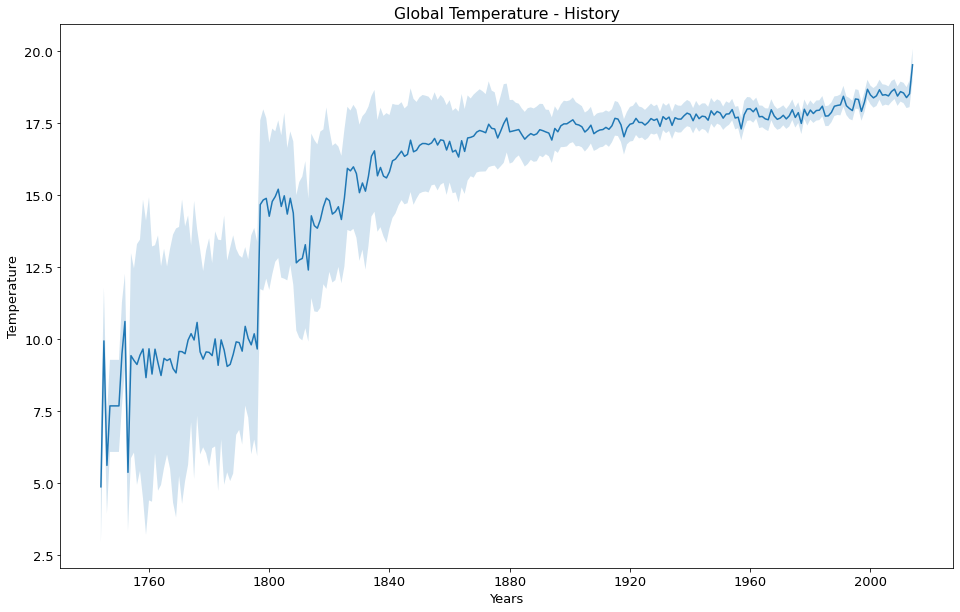

In [133]:
plt.plot(y.index, y.AverageTemperature.values)
plt.fill_between(y.index,
                 y.AverageTemperature.values-y.AverageTemperatureUncertainty,
                 y.AverageTemperature.values+y.AverageTemperatureUncertainty,
                 alpha=0.2, interpolate=True)
plt.title('Global Temperature - History')
plt.xlabel('Years')
plt.ylabel('Temperature')
plt.show()

The temperature is increasing and it is incredibly fast how the increase is happening. Also, our measurement devices and techniques are quite better due to the uncertainty expressed in the data.

Global temperature is huge science field and can be analysed in so many ways that it is almost impossible to address all variables in a single analysis. Features like terrain, geolocalization, how close to the sea and the human behavior are some of the important features that play an important role in this area.

With that said, a city with a known high temperature is going to be chosen in order to perform the analysis. This simplification does not imply lose of importance of any other analysis. But looking at a specific point we can better understand this behavior and extrapolate for other areas/cities.

The chosen city is Dubay. Dubai has two distinct seasons - summer and winter. Summer in Dubai begins around the last week of April and ends around the first week of October. This period is characterized by extremely hot weather, hot winds and high humidity. Due to the city's close proximity to the sea the temperatures in Dubai are slightly milder in summer in comparison to other Gulf cities such as Kuwait City and Riyadh. However, this means the city has high humidity which can make the weather extremely unpleasant in summer. Rainfall is scarce during the summer months, but the windy conditions ensure there are frequent dust storms.

[Source - Climate of Dubai](https://en.wikipedia.org/wiki/Climate_of_Dubai)

In [ ]:
# Targeting the analysis 
CITY = 'Dubai'
YEAR_START = 1900

# Croping and creating month/year columns
df = temp[(temp.City == CITY)]
# df = temp.copy()
df.dt = df.dt.apply(pd.to_datetime)
df['Month'] = df['dt'].dt.month
df['Year'] = df['dt'].dt.year
df = df[df.Year >= 1900]
df.set_index('dt', inplace=True)
df.head()

In [6]:
# Checking for null values
df[df.isnull().any(axis=1)]

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Month,Year
dt,,,,,,,,
2013-09-01,NaN,NaN,Dubai,United Arab Emirates,24.92N,54.98E,9,2013


In [7]:
# Interpolating to fill the NaN value using the "time" method 
#(Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)
df.AverageTemperature.interpolate(method='time', inplace=True)
df.AverageTemperatureUncertainty.interpolate(method='time', inplace=True)

## Data Exploratory

An exploration in the data is perfomed below. There will be a yealy and monthly charts to understand seasonality and the curves shapes.

Text(0, 0.5, 'Uncertainty')

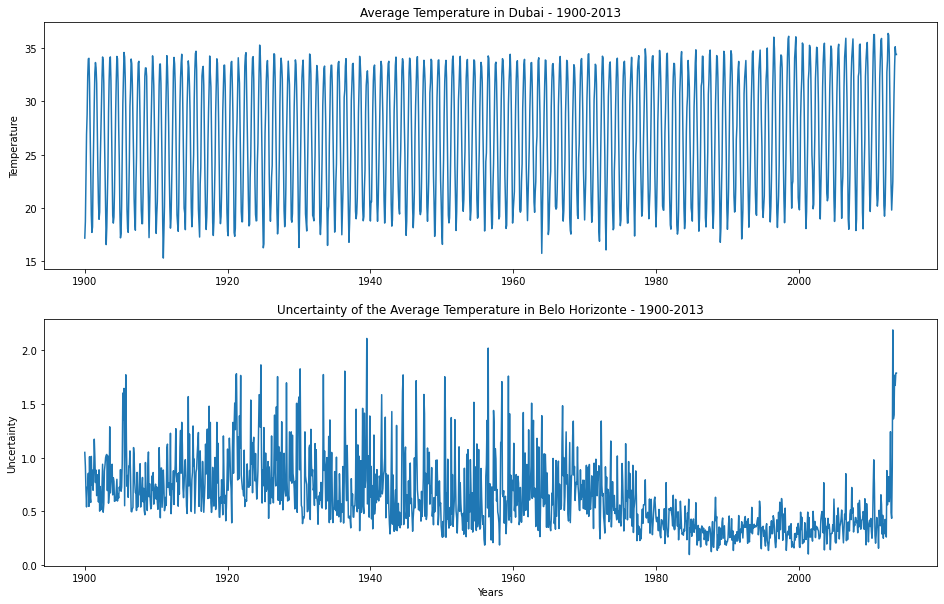

In [8]:
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

#Plotting Average Temperature
ax1.plot(df.AverageTemperature)
ax1.set_title('Average Temperature in '+CITY+' - 1900-2013')
ax1.set_ylabel('Temperature')

#Plotting Average Temperature Uncertainty
ax2.plot(df.AverageTemperatureUncertainty)
ax2.set_title('Uncertainty of the Average Temperature in Belo Horizonte - 1900-2013')
ax2.set_xlabel('Years')
ax2.set_ylabel('Uncertainty')

Over the years, we can see some stationarity in the dataset, but an Adfuller test is going to confirm this. The uncertainty is around 1 degree we can see an increase over the last years. It can indicate some trend in the global warming. 

In [ ]:
# Checking the behavior aggregating by year
pivot = pd.pivot_table(df, values='AverageTemperature', index='Year', aggfunc='mean')
pivot.plot(figsize=(16,10))
plt.title(CITY+' temperature - Yearly (1900-2013)')
plt.xlabel('Years')
plt.ylabel('Average Temperature - Yearly')
plt.xticks([x for x in df.Year.unique()], rotation=45)
plt.legend().remove()
plt.show()

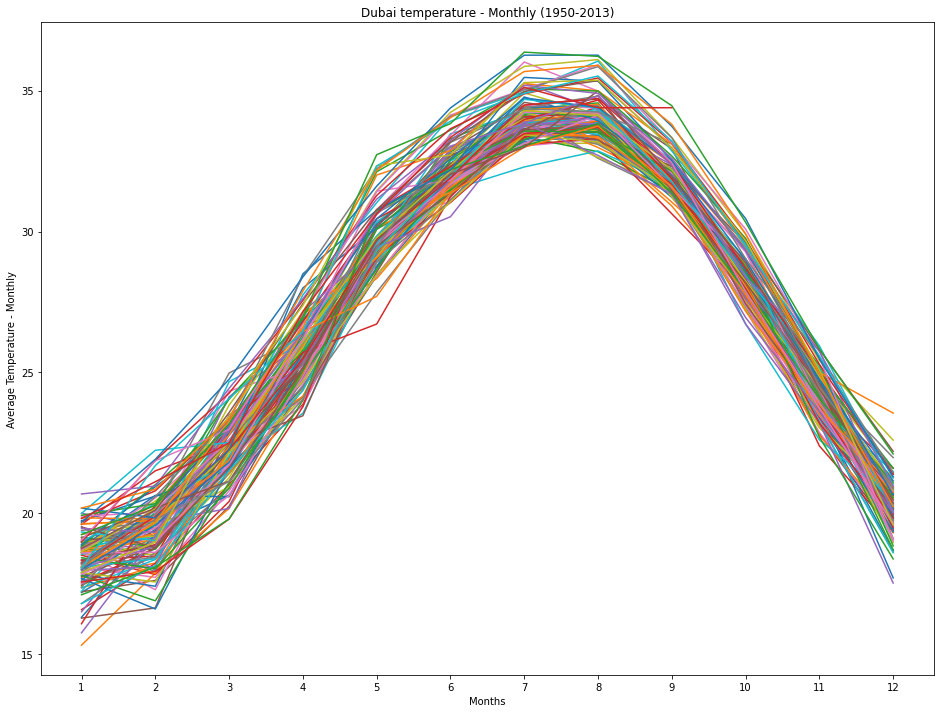

In [10]:
# Checking the behavior aggregating by month
pivot = pd.pivot_table(df, values='AverageTemperature', index='Month', columns='Year', aggfunc='mean')
pivot.plot(figsize=(16,12))
plt.title(CITY+' temperature - Monthly (1950-2013)')
plt.xlabel('Months')
plt.ylabel('Average Temperature - Monthly')
plt.xticks([x for x in df.Month.unique()])
plt.legend().remove()
plt.show()

The above plot is very important because it shows clearly the seasonality of the temperature every year. It is known that the high temperatures can be observed in summer and looking at the plot there is huge pick every year in june/july of 30°C to 35°C.

An interesting behavior is that in 1992 we can se the initial increase of the average temperature in Dubai. The chart below zooms in and shows this increase in details.

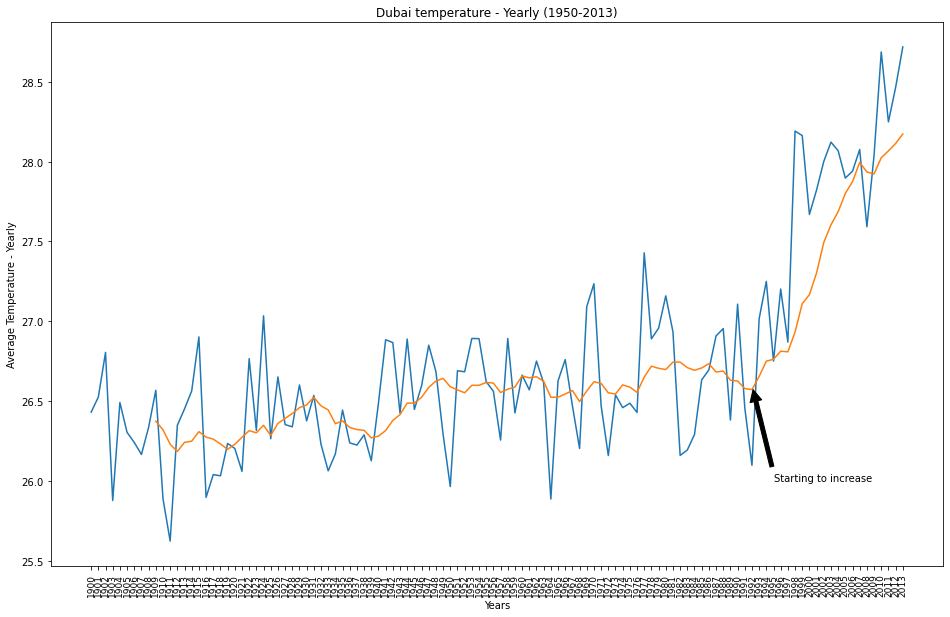

In [11]:
# Looking at the years we can se an increasing...
ROLLING_WINDOW = 10

pivot_yearly = pd.pivot_table(df, values='AverageTemperature', index='Year', aggfunc='mean')
pivot_yearly['Rolling_Window_MA'] = pivot_yearly['AverageTemperature'].rolling(ROLLING_WINDOW).mean()
pivot_yearly[['AverageTemperature','Rolling_Window_MA']].plot(figsize=(16,10))
plt.title(CITY+' temperature - Yearly (1950-2013)')
plt.xlabel('Years')
plt.ylabel('Average Temperature - Yearly')
plt.xticks([x for x in df.Year.unique()], rotation=90, fontsize=9)
plt.legend().remove()
plt.annotate('Starting to increase', xy=(1992, 26.6), xytext=(1995, 26),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

## Summary Statistics

This is an important part of the analysis. Given the data exploratory where we could check the behavior of the serie during the years, before we model this time series and forecast we should test some important features.

First, an Adfuller test is going to be our best tool to determine if the series is stationary or not. Also,  the distribution is placed mostly in two regions that we can think about two normal distributions (one for summer temperatures and other for winter temperatures).

In [ ]:
# Applying Adfuller test to indentify stationarity in the serie
# Source: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
adfuller_resp = adfuller(df.AverageTemperature)

adfuller_analysis = pd.Series(adfuller_resp[0:4], 
                              index=['ADF Statistic','p-value','Lags','# Observations'])
adfuller_analysis = round(adfuller_analysis,5)

for key, value in adfuller_resp[4].items():
        adfuller_analysis["Critical Value (%s)"%key] = value.round(5)
        
if adfuller_analysis[0] < adfuller_analysis[5]:
    print('The presented series seems stationary.')
else:
    print('The series seems to be non-stationary.')

In [13]:
adfuller_analysis

ADF Statistic             -1.86435
p-value                    0.34901
Lags                      24.00000
# Observations          1340.00000
Critical Value (1%)       -3.43524
Critical Value (5%)       -2.86370
Critical Value (10%)      -2.56792
dtype: float64

As the ADF Statistic shows that we cannot reject the null hypothesis what was expected. The temperature has indeed a relation with time as we could observe in the previous charts and there is some stationarity in our data.

Also, there is a lag of 24 which demonstrates a correlation in time of 24 months (2 years). This information is going to be important in our ARIMA model.

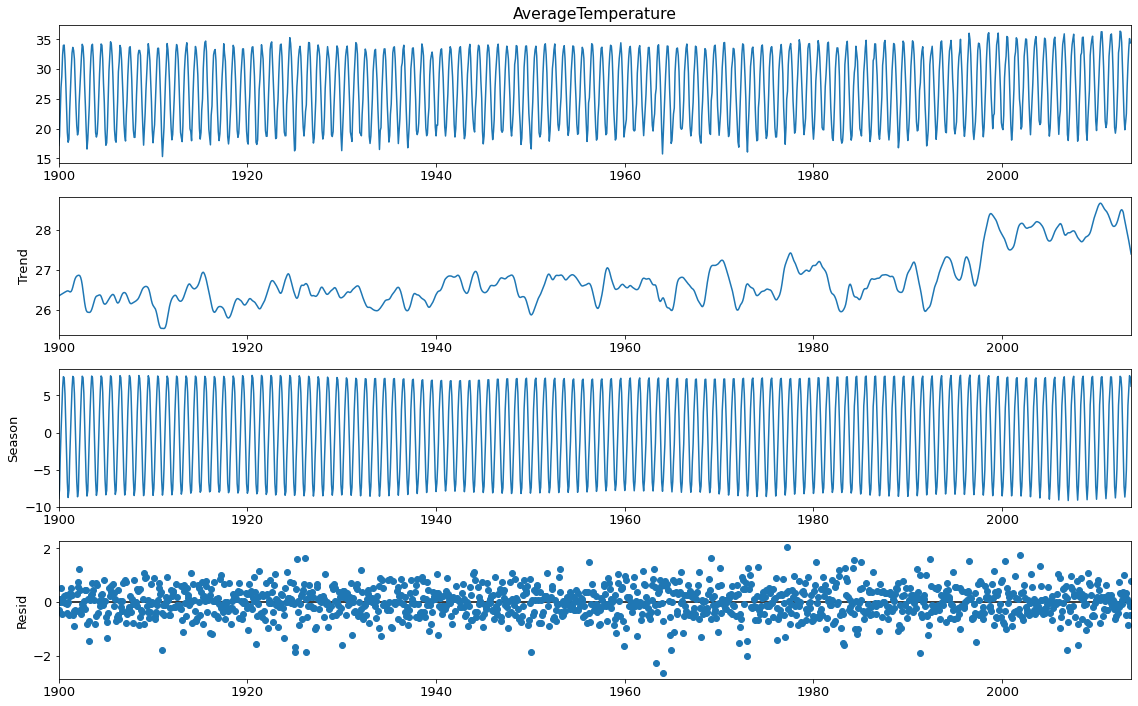

In [16]:
# Using the STL (Season, Trend and Low-pass) to decompose the serie and have a nice view of trend and seasonality
plt.rc('figure',figsize=(16,10))
plt.rc('font',size=13)
stl = STL(df.AverageTemperature, seasonal=13)
res = stl.fit()
fig = res.plot()

The next part the ARIMA parameters is going to be estimated with ACF and PACF plots.

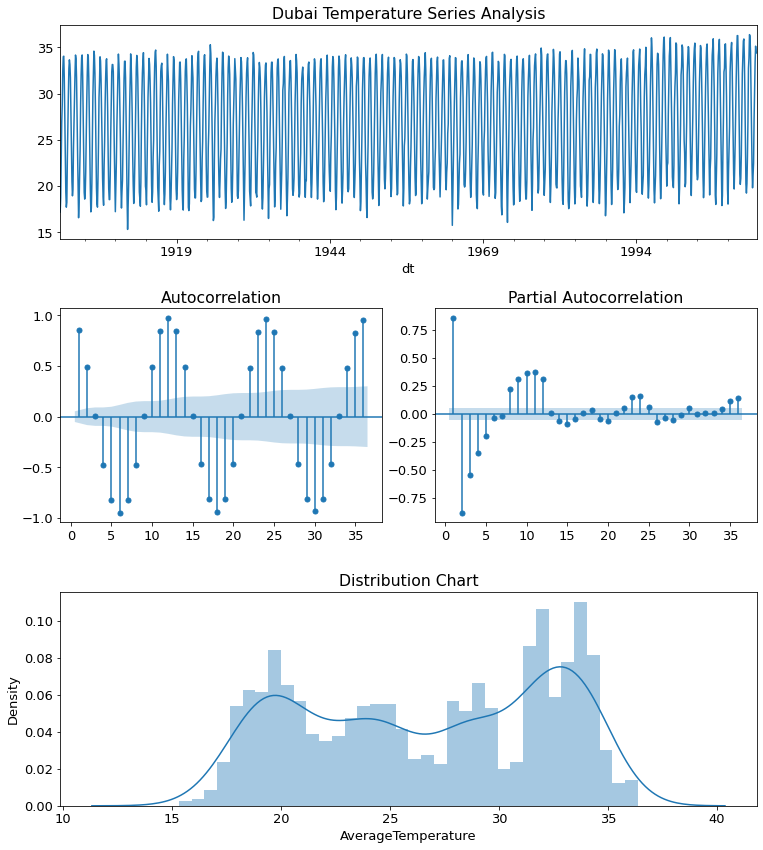

In [17]:
# Define model parameters
lags_plots = 36
figsize=(16,12)

# Creating plots of the DF
y = pd.Series(df.AverageTemperature)
fig = plt.figure()

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))
ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

y.plot(ax=ax1, figsize=figsize)
ax1.set_title(CITY+' Temperature Series Analysis')
plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
ax4.set_title('Distribution Chart')

plt.tight_layout()

As a first approach, we can see the yearly seanonality of the data. Looking at the graphs, we can observe a LAG=3 in the ACF plot. As the data set is not stationary, we can induce in our ARIMA model and then apply and moving average. So, the first model is going to have P=3, D=1 and Q=0.

In [18]:
# Splitting the dataset into train, validation and test to perform dynamic predictions

train_set = df[:-5*12]
val_set   = df[-5*12:-1*12]
test_set  = df[-1*12:]

## Modelling

The modelling is structured in three big parts:

1. Baseline model using Moving Average
2. ARIMA model with the parameters we specified
3. Grid Search to explore (brute force) which parameters fits better in the given scenario

The ARIMA model is going to use an dynamic forecasting approach where we use the $Y_{t-1}$ to predict the $Y_t$ value. Since it is acceptable in this case (temperature forecasting) we have the previous value, this approach seems reasonable.

We also use the [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as a metric in this scenario.

In [19]:
# Creating a baseline model we want to start with
WINDOW=6
baseline = val_set.AverageTemperature.rolling(WINDOW).mean()
baseline.dropna(inplace=True)

In [20]:
# Aux functions
def MAE(y, y_pred):
    return mean_absolute_error(y, y_pred)

def plot_series(y, y_pred, title='Plot Results', y_label='Y', x_label='X'):
    # Plot configs
    plt.figure(figsize=(20,8))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(y.index, y.values)
    plt.plot(y.index, y_pred, color='red')
    # Legend handling
    red_patch = mpatches.Patch(color='red', label='Predicted Temperature')
    blue_patch = mpatches.Patch(color='blue', label='Real Temperature')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [21]:
# Evaluating the Mean Absolute Error of the baseline model
mae_baseline = MAE(val_set.iloc[WINDOW-1:,0],baseline)
print(f'The MAE of the baseline is {round(mae_baseline,4)} celsius degrees')

The MAE of the baseline is 5.2658 celsius degrees


                              ARIMA Model Results                               
Dep. Variable:     D.AverageTemperature   No. Observations:                 1364
Model:                   ARIMA(3, 1, 0)   Log Likelihood               -2584.801
Method:                         css-mle   S.D. of innovations              1.609
Date:                  Mon, 09 Nov 2020   AIC                           5179.602
Time:                          21:13:58   BIC                           5205.693
Sample:                      02-01-1900   HQIC                          5189.368
                           - 09-01-2013                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0077      0.088      0.087      0.931      -0.165       0.181
ar.L1.D.AverageTemperature     0.8200      0.023     35.738      0.

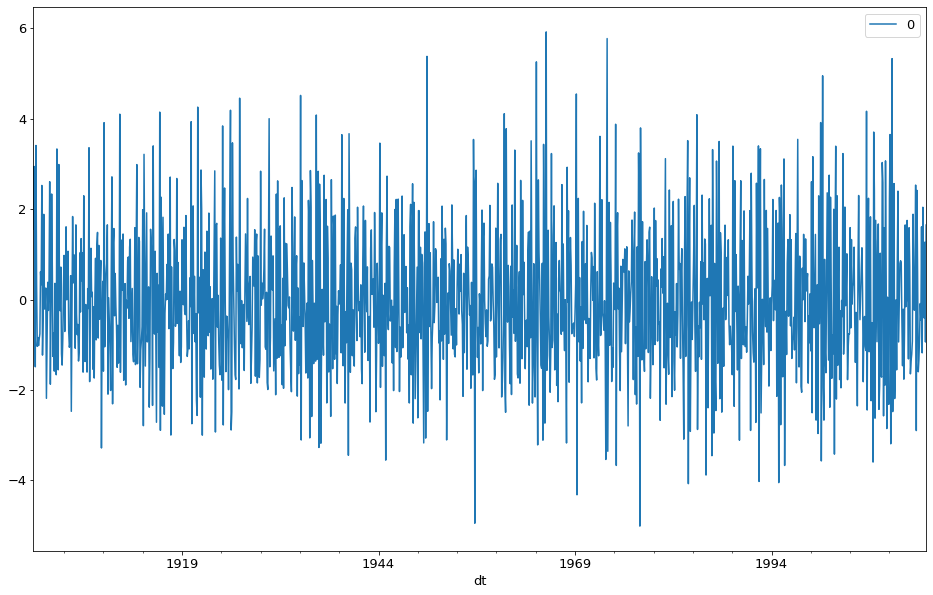

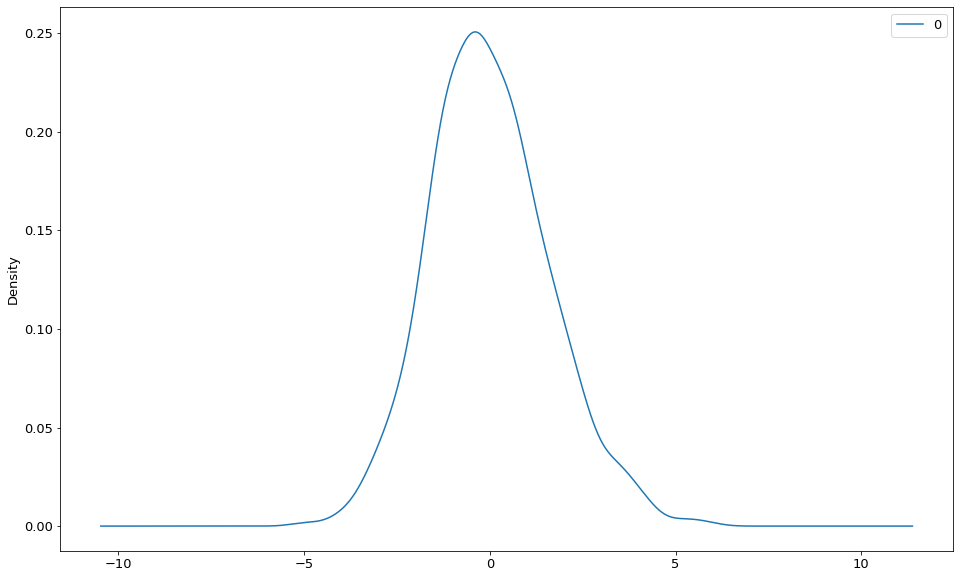

                 0
count  1364.000000
mean      0.002111
std       1.610240
min      -5.008857
25%      -1.098905
50%      -0.112932
75%       0.989888
max       5.915479


In [22]:
# Starting with lag 3 (p=3)
P = 3

# we will use the d = 1 to induce a diff in the dataset
D = 1

# Moving Average we can start with 0
Q = 0

###### Creating the Model ######
model = ARIMA(df.AverageTemperature, order=(P,D,Q))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
###### Creating the Model ######

In [23]:
# The error itself does not appear to have trend and the residual erros are Gaussian

In [24]:
def arima_model(train, val, arima_order, plot=False):
#     train_size = int(len(X) * .7)
#     train, test = X[0:train_size].values, X[train_size:len(X)].values
    history_data = [p for p in train.values]
    prediction = list()

    for t in range(len(val)):
        model = ARIMA(history_data, order=arima_order)
        model_fit = model.fit(disp=0)
        forecast = model_fit.forecast(alpha=0.1)
        y_hat = forecast[0]
        prediction.append(y_hat)
        obs = val[t]
        history_data.append(obs)
    prediction_ = []
    for i in prediction:
        prediction_.append(i[0])

    error = mean_absolute_error(val, prediction_)

    return model_fit, prediction

In [25]:
arima_order = (P,D,Q)
model, prediction = arima_model(train_set.AverageTemperature, val_set.AverageTemperature, arima_order=arima_order, plot=True)

In [26]:
mae_arima = MAE(val_set.AverageTemperature,prediction)
print(f'The MAE of the baseline is {round(mae_arima,4)} celsius degrees')

The MAE of the baseline is 1.3953 celsius degrees


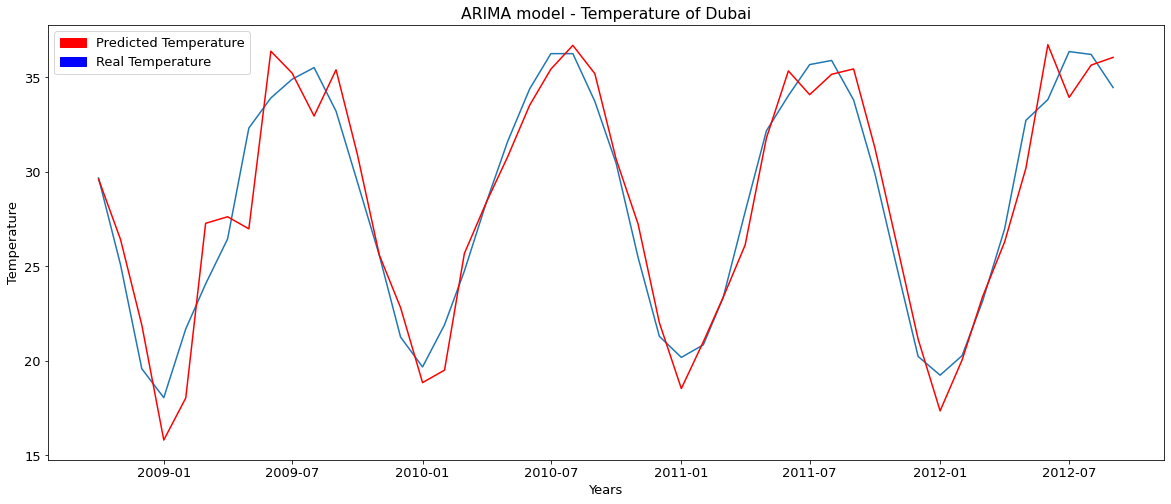

In [27]:
plot_series(y=val_set.AverageTemperature, y_pred=prediction, title='ARIMA model - Temperature of '+CITY, 
            x_label='Years', y_label='Temperature')

The model performs better than the baseline, which is a good indication of the model fits the data well. Moreover, looking at the shape of the validation set, we can see both curves a close to each other. The dynamic forecast has its advantage, but can have future predictions weakened.

In [29]:
forecast, stderr, confidence_interval =  model.forecast(steps=1, alpha=0.1)

print('The next date: ', val_set.index[-1] + pd.DateOffset(months=1), ' will have a temperature of ', round(forecast[0],3))
print('With 99% of centainty, the confidence interval is: ', confidence_interval[0])

The next date:  2012-10-01 00:00:00  will have a temperature of  36.065
With 99% of centainty, the confidence interval is:  [33.41336985 38.7163774 ]


This final part is the grid search where we input a list of values and try to extract the best model possible. As it is a brute force, it is only for demonstrate the applicability and the skill. In real scenarios it should be one of the last parts of a Data Science and Machine Learning project.

The $P$ values are select as months (1,2,6,12) and the others the range from 0 until 2. Since we do not want to have huge differentiation and moving average, it is reasonable these values.

In [33]:
# evaluate combinations of p, d and q values for an ARIMA model (Source: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)
def grid_search_series(p_values, d_values, q_values, plot_=False):
    best_score, best_param = float('inf'), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                
                try:
                    model, prediction = arima_model(train_set.AverageTemperature, val_set.AverageTemperature, arima_order=order)
                    mae_arima_ = MAE(val_set.AverageTemperature,prediction)
                    if mae_arima_ < best_score:
                        best_score, best_param, best_model = mae_arima_, order, model
                    print('ARIMA%s MAE=%.3f' % (order, mae_arima_))
                except:
                    continue
    print('Best ARIMA model has%s and MAE=.3f' % (best_param, best_score))
    
    return best_model

In [34]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 6, 12]
d_values = range(0, 3)
q_values = range(0, 3)

best_model = grid_search_series(p_values=p_values, d_values=d_values, q_values=q_values, plot_=False)

After the Grid Search, the best model is: __ARIMA(12, 1, 2) MAE=0.547__

In [38]:
P,D,Q = 12, 1, 2
arima_order = (P,D,Q)
best_model, prediction = arima_model(train_set.AverageTemperature, val_set.AverageTemperature, arima_order=arima_order, plot=True)

In [65]:
test_forecast = best_model.forecast(12, alpha=.01)

In [69]:
assert test_forecast[0].__len__() == test_set.__len__()

In [78]:
mae_arima = MAE(val_set.AverageTemperature,prediction)
print(f'The MAE of the best ARIMA model is {round(mae_arima,4)} celsius degrees')

The MAE of the best ARIMA model is 0.5468 celsius degrees


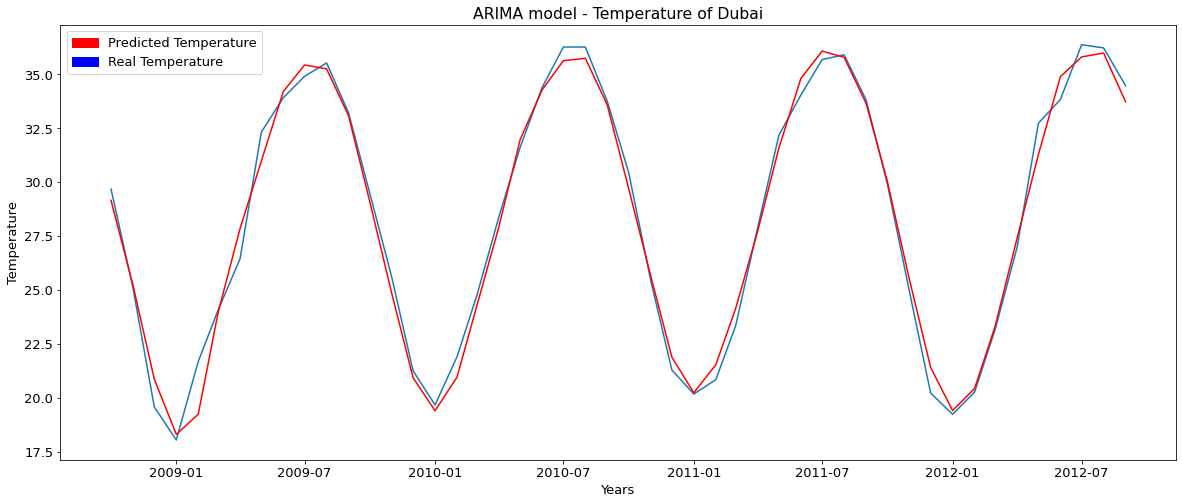

In [60]:
plot_series(y=val_set.AverageTemperature, y_pred=prediction, title='ARIMA model - Temperature of '+CITY, 
            x_label='Years', y_label='Temperature')

After the training and validation being used, we are going to plot the forecast for the test set to evaluate the performance 12 months ahead using the model.

In [77]:
mae_arima_test = MAE(test_set.AverageTemperature,test_forecast[0])
print(f'The MAE of the best ARIMA model against test set is {round(mae_arima,4)} celsius degrees')

The MAE of the best ARIMA model against test set is 2.3531 celsius degrees


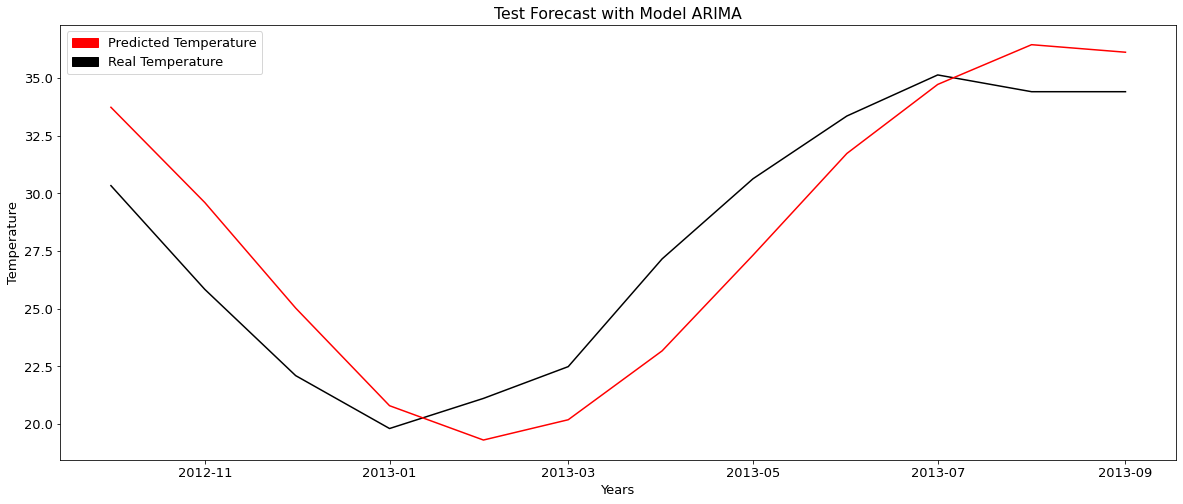

In [74]:
plt.figure(figsize=(20,8))
plt.title('Test Forecast with Model ARIMA')
plt.xlabel('Years')
plt.ylabel('Temperature')
plt.plot(test_set.index, test_set.AverageTemperature, color='black')
plt.plot(test_set.index, test_forecast[0], color='red')
# Legend handling
red_patch = mpatches.Patch(color='red', label='Predicted Temperature')
blue_patch = mpatches.Patch(color='black', label='Real Temperature')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

## Conclusion

In this notebook it was developed an analysis using the temperature of one city as a business case. It an be concluded with this analysis that there is a global warming happening at this moment and we must be aware of that and create tools to raise politics againts this process.

Looking at the notebook only, the Dabai temperature has an increase since 1992 and our model can be used to predict the next month average temperature with confidence. The models developed uses [ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html) as an autoregressive model to capture not only the seasonality but also the moving average.

I consider the results satisfactory given the complexity of the topic. The strategy to use a city only was important to focus on the problem and not the whole picture around this huge topic. For further analysis, it is important to gather data for a country or continent to impact a larger region. Or it can be studied for other countries. It would be important to explore Deep Learning models such as [LSTM for time series](https://www.tensorflow.org/tutorials/structured_data/time_series) or other statistical models that would fit better in the data.

Finally, as business case work it can be used more features and describe not only temperature, but also industrial/production impacts such as agriculture and livestock. Also, there is a high demand for temperature forecast given the new energy sources where temperature plays an important role on wind, solar incidence and many others.